# NLIW depression flux calculations
### Testing to develop better functions for paper submission

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import cmocean.cm as cm
from wootils.plotnice import vert_stack, plot_align, basic_ts
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wootils.plotnice import saveagu, plot_axislabels#, vert_stack, horz_stack, plot_align, basic_ts
from afloat.pca import rotate_2D
from scipy.signal import find_peaks
import wootils.filters as fl
from matplotlib.patches import Ellipse
from afloat.currents import sd_to_uv, uv_to_sd
from matplotlib.colors import to_rgba

import sys
sys.path.insert(0, '../')
from chp3_plotfuncs import *
from chp3_fluxfuncs import get_nliw_times, calc_flux
from chp3_samplefuncs import sample_ssc
    
sns.set()
sns.set_style("white")
sns.set_style("ticks")

pyODAS not found, not importing pIMOS.xrwrap.rsi_vmp


In [2]:
field_trip = 'RS2019'
wave_type = 'NLIW'
temp_file = 'RowleyShoals_Gridded_Mooring_T_SBE56.nc'
moor = 'T150'

In [3]:
# Set key data directories and outputs
project_root = r'/mnt/c/Users/00099894/Large_Data/Experiments'
# work_dir = r'/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/PhD/pl'
load_dir = os.path.join(project_root, field_trip, wave_type)

fig_dir = f'{wave_type}_figures'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

## Load the data for event 5

In [4]:
# Load temp data
temp_nc = os.path.join(project_root, field_trip, temp_file)
ds_temp = xr.open_dataset(temp_nc, group=moor)
ds_temp.close()

In [5]:
wav_tx = get_nliw_times()

# c_wave = 0.6
# cb_labels = ['$\\overline{C_{max}}$', '$\\overline{U_{max}}$', '$\\overline{W_{max}}$', '$\\langle w\'c\' \\rangle_{max}$',\
#                            '$\\langle w\'w\' \\rangle_{max}$', '$L_W$', '$R_{ISW}$', 'Good']
cb_short = ['$S_{obs}$', '$S_{est}$', '$S_{theory}$']

cb_labels = ['$\\overline{C}_{max}$', '$\\overline{U}^2_{max}$', '$\\overline{W}_{max}$',\
             '$\\overline{w\'w\'}_{max}$', '$\\overline{w\'c\'}_{max}$',\
             '$S_{est}$', '$L_W$', '$-ka$', '$R_{ISW}$', '$-A_1$']

df_all = pd.DataFrame(columns=cb_labels)

In [6]:
df = pd.DataFrame(columns=cb_short)

spd_mean = []
spd_std = []
dir_mean = []
dir_std = []
int_dir = []
u_bt = []
v_bt = []
m1_amp = []
half_L = []

Loaded NLIW_E1_fluxattrs.nc
-29.017313194071413
261.1620739509719
Loaded NLIW_E2_fluxattrs.nc
-42.71130577943973
324.79435163789367
Loaded NLIW_E3_fluxattrs.nc
-39.56572213686216
358.5490040720226
Loaded NLIW_E4_fluxattrs.nc
-25.891753395595067
267.0579555221875
Loaded NLIW_E5_fluxattrs.nc
-43.9694588934602
292.0627829277127
Loaded NLIW_E6_fluxattrs.nc
-32.30475514081997
477.19177024399846
Loaded NLIW_E7_fluxattrs.nc
-31.537117595700725
733.1943749714525
Loaded NLIW_E8_fluxattrs.nc
-29.035629704774102
353.16880784841635
Loaded NLIW_E9_fluxattrs.nc
-14.582305880206698
522.1771496923874
Loaded NLIW_E10_fluxattrs.nc
-20.286912027836213
200.1665314001963
Loaded NLIW_E11_fluxattrs.nc
-26.494887527894555
192.00977222539007


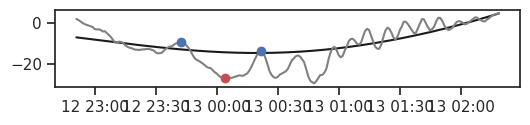

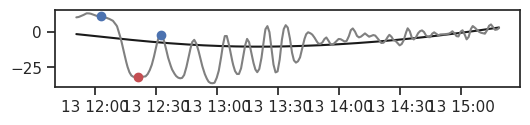

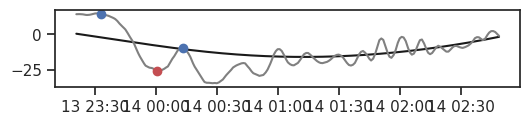

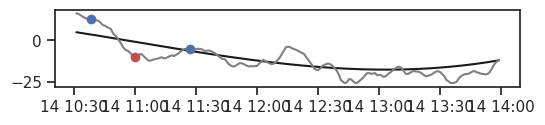

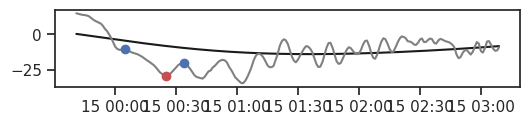

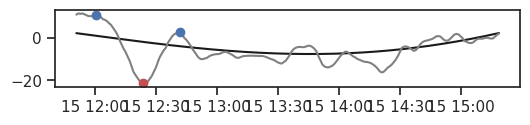

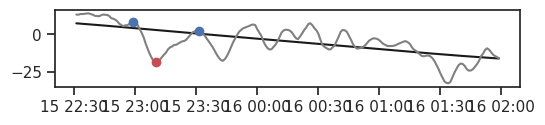

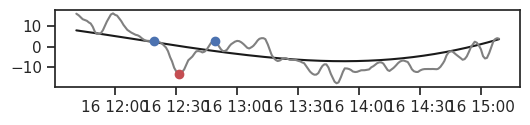

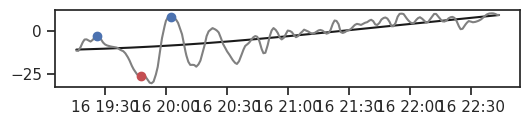

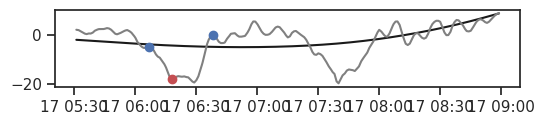

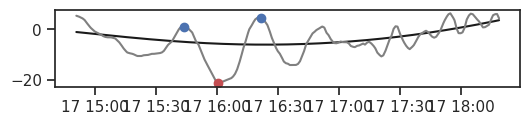

In [7]:
for ii, wt in enumerate(wav_tx):
    
    # Load fluxes
    sig_fil = f'{wave_type}_E{int(ii+1)}_fluxattrs.nc'
    vel_file = os.path.join(load_dir, sig_fil)
    if os.path.exists(vel_file):
        ds = xr.open_dataset(vel_file)
        xr.Dataset.close(ds)
        print(f'Loaded {sig_fil}')

        ## Extract the barotropic u,v

        # First highpass filter the m1 amp
        ds_tstep = np.median(np.diff(ds['time'].values)) / np.timedelta64(1, 'm')
        m1, nan_lx, nan_ex = fl.trim_edge_nans_xr(ds['mode_1'])
        m1_hp = xr.apply_ufunc(fl.filter1d, m1, 6, ds_tstep, 'highpass',\
                                input_core_dims=[['time'],[],[],[]], output_core_dims=[['time']],\
                                vectorize=True)
        m1_hp_rl = m1_hp.rolling(time=50, center=True).mean()
        
        # Select the first negative peak less than -18m
        px, pp = find_peaks(-m1_hp_rl, height=8, distance=100)
        ix_min = px[0]   #np.argmin(m1_hp.values)

        # Quick plot to check
        plt.figure(figsize=(6,1))
        plt.plot(ds['time'][nan_lx:nan_ex], ds['mode_1'][nan_lx:nan_ex] - m1_hp, c='k')
        plt.plot(ds['time'][nan_lx:nan_ex], ds['mode_1'][nan_lx:nan_ex], c='grey')
        # plt.plot(ds['time'][nan_lx:nan_ex], (m1_hp_rl + m1_hp), c='grey')
        plt.plot(ds['time'][nan_lx:nan_ex][ix_min],\
                 ds['mode_1'][nan_lx:nan_ex][ix_min], 'ro')
        print(ds['mode_1'][nan_lx:nan_ex][ix_min].values - ds['mode_1'][nan_lx:nan_ex][0].values)
        # m1_amp.append(ds['mode_1'][nan_lx:nan_ex][ix_min].values - ds['mode_1'][nan_lx:nan_ex][0].values)
        
        # Now get u,v at this time
        u_ix = ds['e_tide'][ix_min + nan_lx - 5:ix_min + nan_lx + 5].mean(dim='time').values
        v_ix = ds['n_tide'][ix_min + nan_lx - 5:ix_min + nan_lx + 5].mean(dim='time').values
        u_bt.append(u_ix)
        v_bt.append(v_ix)

        ## Now get the speed and direction
        df.loc[ii, cb_short[0]] = ds.attrs['obs_celerity'][0]

        u_obs, v_obs = sd_to_uv(ds.attrs['obs_celerity'][0],\
                                ds.attrs['theta'][0] + np.deg2rad(ds.attrs['heading']),\
                                convention='ocean')
        spd_est, dir_est = uv_to_sd(u_obs - u_ix, v_obs - v_ix, convention='ocean')
        df.loc[ii, cb_short[1]] = spd_est

        df.loc[ii, cb_short[2]] = ds.attrs['m1_celerity'][0]

        spd_mean.append(ds.attrs['obs_celerity'][0])
        spd_std.append(ds.attrs['obs_celerity'][1])
        dir_mean.append(ds.attrs['theta'][0])
        dir_std.append(ds.attrs['theta'][1])
        int_dir.append(ds.attrs['heading'])

        # Half wavelength - get time lag between first two peaks in M1
        # ds_tstep = np.median(np.diff(ds['time'].values)) / np.timedelta64(1, 'm')
        # diss = 10 / ds_tstep
        # w_peakx,wpk = find_peaks(m1_hp[:int(len(m1_hp)/2)], distance=diss, height=0.)  
        # ix = np.argmax(wpk['peak_heights'])

        # Find index of first time after ix_min that difference in negative
        diff_m1 = np.diff(m1_hp_rl)
        offset = 300
        if (ii==3) | (ii==9) | (ii==8):
            diff_e = ix_min + offset + np.where(diff_m1[(ix_min+offset):] < -0.01)[0][0]
        else:
            diff_e = ix_min + np.where(diff_m1[ix_min:] < -0.01)[0][0]
        diff_s = np.where(diff_m1[:(ix_min-100)] > 0)[0][-1]

        # m1_amp.append(ds['mode_1'][nan_lx:nan_ex][ix_min].values - ds['mode_1'][nan_lx:nan_ex][diff_s].values)
        m1_amp.append(m1_hp[ix_min].values - m1_hp[diff_s].values)

        half_wavelength = ((ds['time'][diff_e] -  ds['time'][diff_s]).values \
                           / np.timedelta64(1, 's')) * ds.attrs['obs_celerity'][0] / 2
        half_L.append(half_wavelength)
        print(half_wavelength)

        plt.plot(ds['time'][nan_lx:nan_ex][diff_s],\
                 ds['mode_1'][nan_lx:nan_ex][diff_s], 'bo')
        plt.plot(ds['time'][nan_lx:nan_ex][diff_e],\
                 ds['mode_1'][nan_lx:nan_ex][diff_e], 'bo')

# Comparison section


In [8]:
from chp3_basefuncs import load_traces_new
work_dir = r'/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/PhD'
field_trip = 'RS2019'   
t1, t2 = load_traces_new(os.path.join(work_dir, 'pl'), field_trip)

In [9]:
(0.6 * 150) / (1.04*10**-6)

86538461.53846154

In [10]:
10**8

100000000

In [11]:
# Load wave data
c_uq = []
spd_uq = []
isw_uq = []

for ii, wt in enumerate(wav_tx):
    
    if ii > -1:
        # Load fluxes
        sig_fil = f'{wave_type}_E{int(ii+1)}_fluxattrs.nc'
        vel_file = os.path.join(load_dir, sig_fil)
        ds = xr.open_dataset(vel_file)
        xr.Dataset.close(ds)
        print(f'Loaded {sig_fil}')

        # sig_fil = f'{wave_type}_{int(ii+1)}_ENU.nc'
        # vel_file = os.path.join(load_dir, sig_fil)
        # ds_turb = xr.open_dataset(vel_file)
        # xr.Dataset.close(ds_turb)

        ## Add the dataframe info - averaging between 3 - 4 m

        # Cmax
        df_all.loc[ii, cb_labels[0]] = float(ds['c_mean'].sel(height=slice(3, 4)).mean(dim='height').max().values)
        # beam_n = ds['echo_corrected'].sel(height=slice(3, 4)).mean(dim='height').max().values
        # c_samp = np.full(1000, np.nan)
        # for ss in range(1000):
        #     c_samp[ss] = sample_ssc(beam_n, t1, t2)
        # c_uq.append([np.percentile(c_samp, 2.5), np.percentile(c_samp, 97.5)])

        # Umax - ISW component
        u_mean_all = ds['u_mean'].sel(height=slice(3, 4)).mean(dim='height')
        ds_tstep = np.median(np.diff(u_mean_all['time'].values)) / np.timedelta64(1, 'm')
        u_mean_highpass = xr.apply_ufunc(fl.filter1d, u_mean_all, 6, ds_tstep, 'highpass',\
                input_core_dims=[['time'],[],[],[]], output_core_dims=[['time']],\
                vectorize=True)
        df_all.loc[ii, cb_labels[1]] = float(np.abs(u_mean_highpass).max().values)

        # Wmax
        df_all.loc[ii, cb_labels[2]] = float((ds['w_mean'].sel(height=slice(3, 4)).mean(dim='height')).max().values)

        # w'c' max
        df_all.loc[ii, cb_labels[4]] = float(ds['wc_turb'].sel(height=slice(3, 4)).mean(dim='height').max().values)

        # w'w' max
        df_all.loc[ii, cb_labels[3]] = 1000*float(ds['w2_turb'].sel(height=slice(3, 4)).mean(dim='height').max().values)

        # R_ISW - Reynolds internal solitary wave number
        u_max = u_mean_highpass.max().values
        # df_all.loc[ii, cb_labels[6]] = ds.attrs['m1_celerity'][0]
        # df_all.loc[ii, cb_labels[4]] = ds.attrs['obs_celerity'][0]
        df_all.loc[ii, cb_labels[5]] = ds.attrs['est_celerity']
        spd_uq.append([ds.attrs['est_celerity'] - 2*ds.attrs['obs_celerity'][1],\
                        ds.attrs['est_celerity'] + 2*ds.attrs['obs_celerity'][1]])
        
        # # Half wavelength - get time lag between first two peaks in W
        half_wavelength = half_L[ii-1]

        df_all.loc[ii, cb_labels[6]] = half_wavelength
        df_all.loc[ii, cb_labels[7]] = -1*m1_amp[ii-1] / (2*half_wavelength)
        re_isw = u_max * np.sqrt(half_wavelength / (1.04*10**-6 * (u_max + df_all.loc[ii, cb_labels[5]])))
        df_all.loc[ii, cb_labels[8]] = re_isw
        df_all.loc[ii, cb_labels[9]] = -1*m1_amp[ii-1]

df_all

Loaded NLIW_E1_fluxattrs.nc
Loaded NLIW_E2_fluxattrs.nc
Loaded NLIW_E3_fluxattrs.nc
Loaded NLIW_E4_fluxattrs.nc
Loaded NLIW_E5_fluxattrs.nc
Loaded NLIW_E6_fluxattrs.nc
Loaded NLIW_E7_fluxattrs.nc
Loaded NLIW_E8_fluxattrs.nc
Loaded NLIW_E9_fluxattrs.nc
Loaded NLIW_E10_fluxattrs.nc
Loaded NLIW_E11_fluxattrs.nc


,$\overline{C}_{max}$,$\overline{U}^2_{max}$,$\overline{W}_{max}$,$\overline{w'w'}_{max}$,$\overline{w'c'}_{max}$,$S_{est}$,$L_W$,$-ka$,$R_{ISW}$,$-A_1$
0,4.927237,0.280883,0.00695,0.415347,0.012717,0.2756,192.009772,0.055779,3549.40364,21.420269
1,23.472021,0.508291,0.011197,0.576633,0.055941,0.297947,261.162074,0.031321,5216.002314,16.359854
2,19.102987,0.457425,0.007725,0.511892,0.039496,0.358915,324.794352,0.062857,4908.691238,40.83137
3,10.217449,0.204658,0.00709,0.603421,0.026897,0.275461,358.549004,0.04733,5484.189425,33.94052
4,9.4813,0.348694,0.007427,0.385152,0.017403,0.315808,267.057956,0.033966,4791.898223,18.141672
5,10.021504,0.35767,0.009081,0.295595,0.023106,0.473588,292.062783,0.025785,2408.987528,15.061783
6,2.289363,0.239713,0.011198,0.240923,0.006442,0.812016,477.19177,0.030762,3846.469634,29.359105
7,1.298321,0.112731,0.005231,0.155449,0.001814,0.410725,733.194375,0.017166,4137.108649,25.172221
8,3.62801,0.254671,0.006451,0.159879,0.001263,0.44271,353.168808,0.019833,4179.044637,14.008502
9,4.165038,0.259247,0.006926,0.193266,0.010169,0.20918,522.17715,0.02286,5384.269687,23.873966


In [12]:
df_all.to_csv(os.path.join(fig_dir, f'{wave_type}_fluxes.csv'))

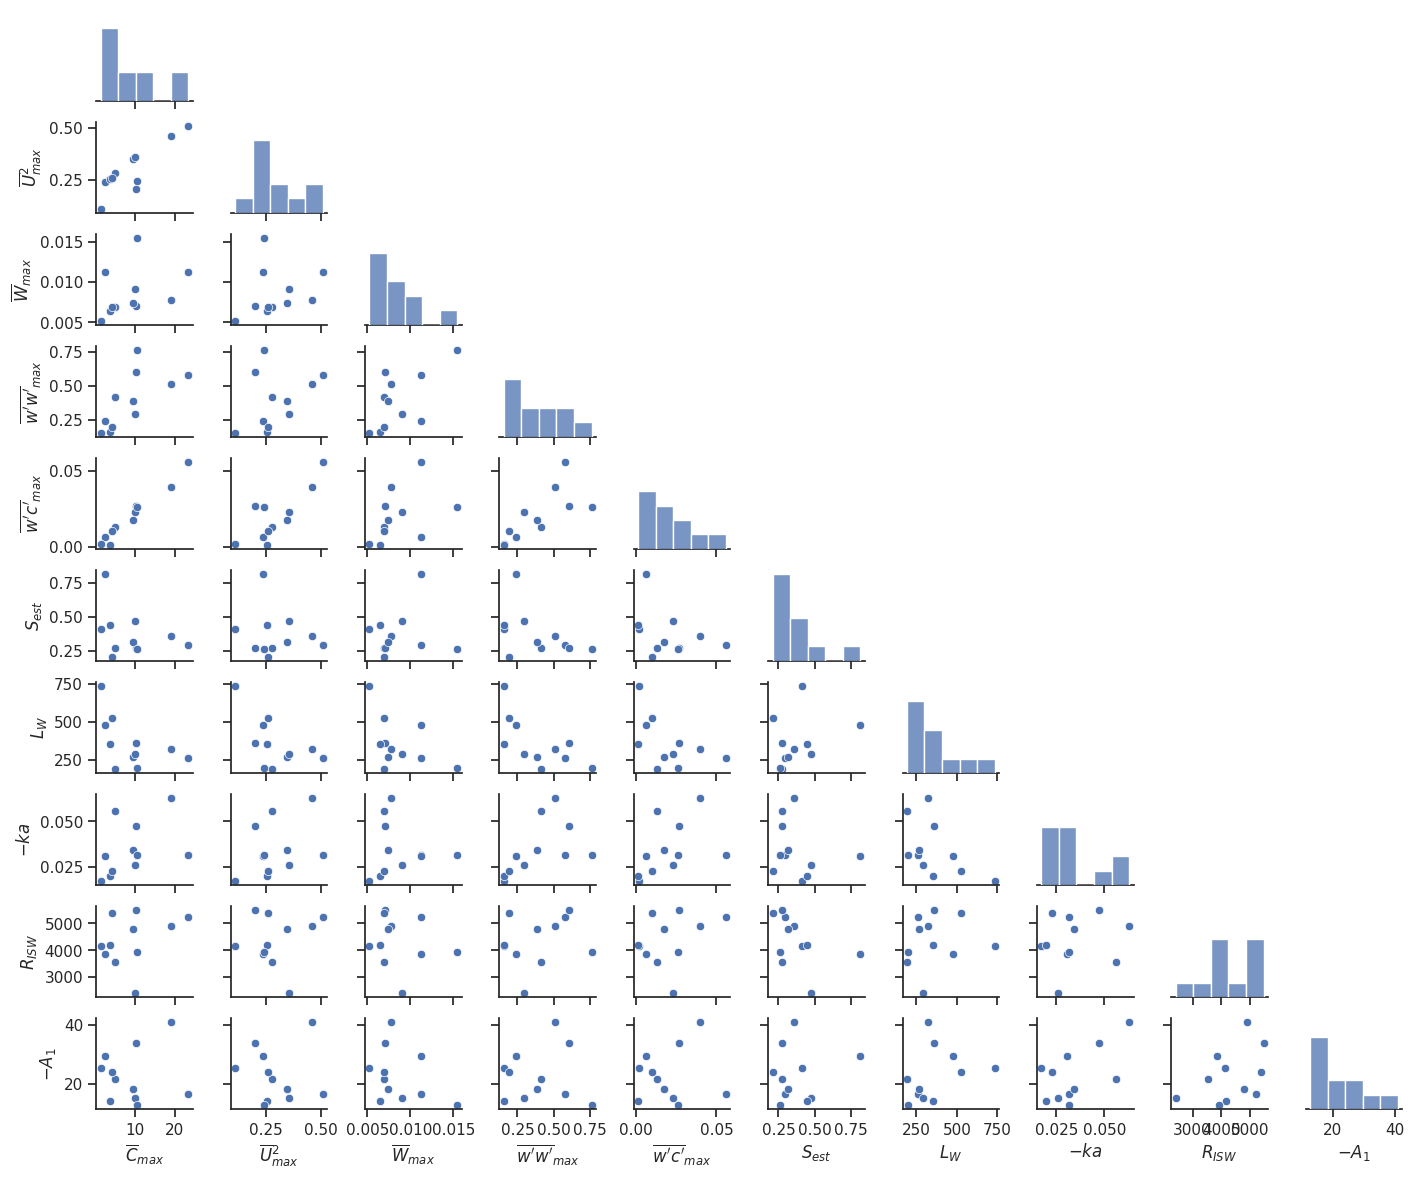

In [13]:
sns.pairplot(data=df_all, corner=True, diag_kind='hist', height=1.2, aspect=1.2)

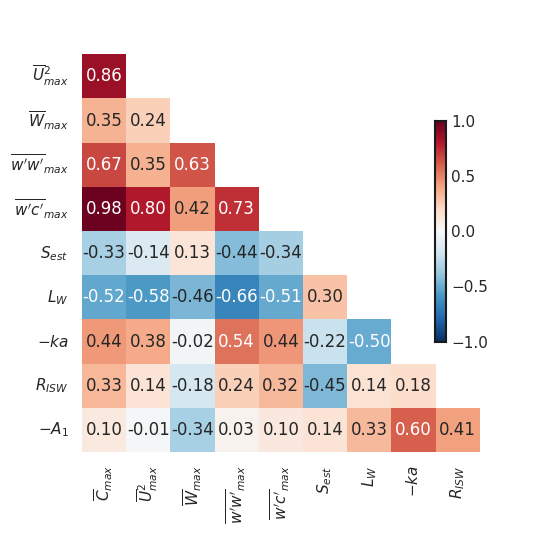

In [14]:
# Plot a correlation heatmap of the data
corr = df_all.iloc[:,:].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(1,1, figsize=(5.5, 5.5))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', vmin=-1, vmax=1, square=True, annot=True,\
            fmt='.2f', cbar_kws={"shrink": .5, 'pad':-0.2})
cbar_ax = fig.axes[-1]

# Make ticks invisible
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, right=False, left=False, labelleft=True)

xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels[-1] = ''
ax.set_xticklabels(xlabels)

ylabels = [item.get_text() for item in ax.get_yticklabels()]
ylabels[0] = ''
ax.set_yticklabels(ylabels)

cbar_ax.tick_params(width=0, length=0, direction='in')
for axis in ['top','bottom','left','right']:
    cbar_ax.spines[axis].set_visible(True)
    cbar_ax.spines[axis].set_linewidth(1.5)
    cbar_ax.spines[axis].set_color('k')

plt.tight_layout()

In [15]:
saveagu(os.path.join(fig_dir, f'{wave_type}_corr_f1v2'), fig)

### Pop out speed outlier and re-do to check

In [16]:
# df_test = df_all.drop([1], inplace=False)

# # Plot a correlation heatmap of the data
# corr = df_test.iloc[:,:].corr()
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True
# fig, ax = plt.subplots(1,1, figsize=(5, 5))
# sns.heatmap(corr, mask=mask, cmap='RdBu_r', vmin=-1, vmax=1, square=True, annot=True,\
#             fmt='.2f', cbar_kws={"shrink": .5, 'pad':-0.2})
# cbar_ax = fig.axes[-1]

# # Make ticks invisible
# plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, right=False, left=False, labelleft=True)

# xlabels = [item.get_text() for item in ax.get_xticklabels()]
# xlabels[-1] = ''
# ax.set_xticklabels(xlabels)

# ylabels = [item.get_text() for item in ax.get_yticklabels()]
# ylabels[0] = ''
# ax.set_yticklabels(ylabels)

# cbar_ax.tick_params(width=0, length=0, direction='in')
# for axis in ['top','bottom','left','right']:
#     cbar_ax.spines[axis].set_visible(True)
#     cbar_ax.spines[axis].set_linewidth(1.5)
#     cbar_ax.spines[axis].set_color('k')

# plt.tight_layout()

In [17]:
c_uq

[]

In [18]:
outlier = 5

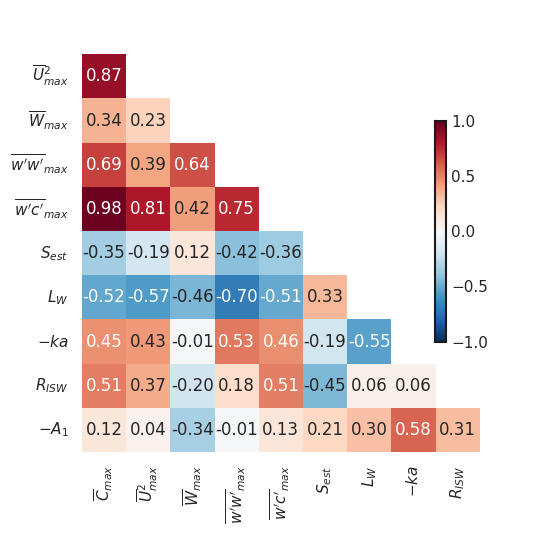

In [19]:
df_all_drop = df_all.drop([outlier], inplace=False)

# Plot a correlation heatmap of the data
corr = df_all_drop.iloc[:,:].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(1,1, figsize=(5.5, 5.5))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', vmin=-1, vmax=1, square=True, annot=True,\
            fmt='.2f', cbar_kws={"shrink": .5, 'pad':-0.2})
cbar_ax = fig.axes[-1]

# Make ticks invisible
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, right=False, left=False, labelleft=True)

xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels[-1] = ''
ax.set_xticklabels(xlabels)

ylabels = [item.get_text() for item in ax.get_yticklabels()]
ylabels[0] = ''
ax.set_yticklabels(ylabels)

cbar_ax.tick_params(width=0, length=0, direction='in')
for axis in ['top','bottom','left','right']:
    cbar_ax.spines[axis].set_visible(True)
    cbar_ax.spines[axis].set_linewidth(1.5)
    cbar_ax.spines[axis].set_color('k')

plt.tight_layout()

In [20]:
saveagu(os.path.join(fig_dir, f'{wave_type}_corr_noout_f1v2'), fig)

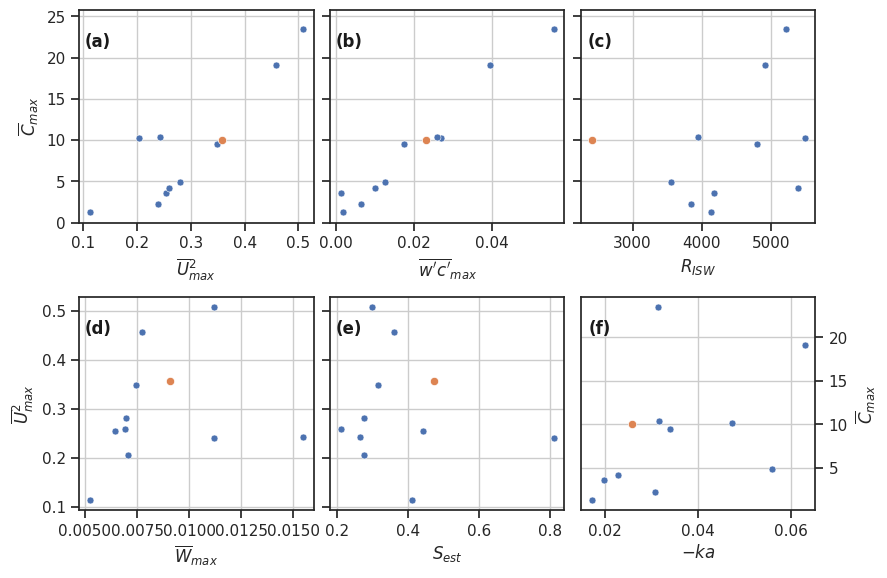

In [21]:
# Setup the interesting scatter plots
fig, ax = plt.subplots(2, 3, figsize=(9.5, 6.5), gridspec_kw={'wspace':0.07, 'hspace':0.35})

# Umax_all vs Cmax
sns.scatterplot(x=df_all[cb_labels[1]], y=df_all[cb_labels[0]], s=25, ax=ax[0][0])
sns.scatterplot(x=[df_all[cb_labels[1]].iloc[outlier]], y=[df_all[cb_labels[0]].iloc[outlier]], s=35, ax=ax[0][0])

# w'w' vs Cmax
sns.scatterplot(x=df_all[cb_labels[4]], y=df_all[cb_labels[0]], s=25, ax=ax[0][1])
sns.scatterplot(x=[df_all[cb_labels[4]].iloc[outlier]], y=[df_all[cb_labels[0]].iloc[outlier]], s=35, ax=ax[0][1])

# w'c' vs Cmax
sns.scatterplot(x=df_all[cb_labels[8]], y=df_all[cb_labels[0]], s=25, ax=ax[0][2])
sns.scatterplot(x=[df_all[cb_labels[8]].iloc[outlier]], y=[df_all[cb_labels[0]].iloc[outlier]], s=35, ax=ax[0][2])

for x in ax[0]:
    x.set_ylim(0, df_all[cb_labels[0]].max()*1.1)
    xl = x.get_xlim()
    # if x == ax[0][0]:
    #     x.set_xlim(0.2, xl[1]*1.1)
    # elif x == ax[0][1]:
    #     x.set_xlim(0, xl[1]*1.1)
    # elif x == ax[0][2]:
    #     x.set_xlim(1000, xl[1]*1.1)    
    x.grid()
    if x != ax[0][0]:
        x.set_ylabel('')
        x.set_yticklabels([])

# Umax_all vs w'c'
sns.scatterplot(x=df_all[cb_labels[2]], y=df_all[cb_labels[1]], s=25, ax=ax[1][0])
sns.scatterplot(x=[df_all[cb_labels[2]].iloc[outlier]], y=[df_all[cb_labels[1]].iloc[outlier]], s=35, ax=ax[1][0])

# w'w' vs w'c'
sns.scatterplot(x=df_all[cb_labels[5]], y=df_all[cb_labels[1]], s=25, ax=ax[1][1])
sns.scatterplot(x=[df_all[cb_labels[5]].iloc[outlier]], y=[df_all[cb_labels[1]].iloc[outlier]], s=35, ax=ax[1][1])

# Umax_all vs w'w'
sns.scatterplot(x=df_all[cb_labels[7]], y=df_all[cb_labels[0]], s=25, ax=ax[1][2])
sns.scatterplot(x=[df_all[cb_labels[7]].iloc[outlier]], y=[df_all[cb_labels[0]].iloc[outlier]], s=35, ax=ax[1][2])

for x in ax[1]:
    yl = x.get_ylim()
    # x.set_ylim(0, yl[1]*1.1)
    # if x == ax[1][0]:
    #     x.set_xlim(0, xl[1]*1.05)
    #     x.set_yticks(np.arange(0.1, 0.41, 0.1))
    #     x.set_ylim(0.1, 0.49)
    # elif x == ax[1][1]:
    #     x.set_yticks(np.arange(0.1, 0.41, 0.1))
    #     x.set_ylim(0.1, 0.49)
    # if x == ax[1][2]:
        # x.set_xticks(np.arange(-0.035, -0.014, 0.01))
    #     x.set_ylim(0.2, 0.98) 

    xl = x.get_xlim()
    # x.set_xlim(0, xl[1]*1.05)
    x.grid()

    if (x == ax[1][1]):
        x.set_ylabel('')
        x.set_yticklabels([])

# For final axis move ticks and labels to right
ax[-1][-1].yaxis.tick_right()
ax[-1][-1].yaxis.set_label_position("right")
plot_axislabels(ax.flatten(), xpos=0.08)

In [22]:
saveagu(os.path.join(fig_dir, f'{wave_type}_scatters'), fig)